<a href="https://colab.research.google.com/github/AshkanSamavatian/Text-Mining-Final-Project/blob/main/Text_Mining_and_Sentiment_Analysis_Final_Project(Ashkan_Samavatian)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Importing necessary libraries and Import Data from Kaggle**

In [ ]:
#Importing fundamental libraries for the project
import os
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

#Importing libraries for text preprocessing
import string
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

#Importing libraries of classification algorithms
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, RocCurveDisplay, make_scorer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#Importing Dataset from Kaggle website with my kaggle_username and kaggle_key
os.environ['KAGGLE_USERNAME']="*****"                            #For presenteing the project, I substituted my kaggle username with "*****"
os.environ['KAGGLE_KEY']="*****"                                 #For presenteing the project, I substituted my kaggle key with "*****"
!kaggle datasets download -d danofer/sarcasm

#Unzipping only the "train-balanced-sarcasm.csv" file
!unzip sarcasm.zip train-balanced-sarcasm.csv

100% 216M/216M [00:02<00:00, 102MB/s]
100% 216M/216M [00:02<00:00, 84.8MB/s]
Archive:  sarcasm.zip
  inflating: train-balanced-sarcasm.csv  


### **Extracting a subset for the project**

In [ ]:
#Reading and storing the dataset
reddit_df=pd.read_csv("train-balanced-sarcasm.csv")

#Extracting a random subset for the project
reddit_sample=reddit_df.sample(frac=0.1, replace=False, random_state=101)

#Monitoring the subset
reddit_sample.head(10)

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
174414,0,"Yeah, she only made you hate ~50% of the world...",Root176400,TwoXChromosomes,3,-1,-1,2016-11,2016-11-21 23:33:57,I think people are not just one thing. If my m...
23668,0,"It's not gay if you say ""no homo"" first.",Flutterfinn,creepyPMs,4,-1,-1,2016-11,2016-11-02 02:50:28,"So, a guy hits on you, but at the same time sa..."
860083,1,Yea man she has a favorite wedding photo that ...,DevsiK,pics,10,10,0,2014-01,2014-01-29 06:50:11,I thought it would be pretty damn self-centere...
284844,0,"We might not be the majority, but I'll be damn...",gannonburgett,Fishing,8,8,0,2016-08,2016-08-09 03:15:58,Don't see much from my home state of Indiana o...
761506,1,Such an outrage over Aragorn and Arwen in the ...,CaPTaIn_Chemistry,todayilearned,1,1,0,2015-01,2015-01-11 19:24:20,"Whether or not it was thrown in or not, pretty..."
632219,1,Because they're valiant soldiers in the fight ...,stupid_wiseman,AskReddit,1,1,0,2015-10,2015-10-24 00:24:44,Why do stereotypical SJW types feel the need t...
748636,0,i searched but i didnt find anything,creeperlwd,pcmasterrace,1,1,0,2015-01,2015-01-07 16:52:13,I know the K means it is unlocked. Not sure if...
330163,1,Human centipede,Onecooldude123,AskReddit,1,1,0,2016-05,2016-05-10 20:48:58,What are some movies everyone MUST see at leas...
672466,0,protagonist survives,AuraMasterNeal,AskReddit,1,1,0,2015-06,2015-06-04 21:28:06,How could you spoil a movie or TV show using t...
934154,0,Im surprised the MMPA and RIAA have not sued t...,lethal_weapon_five,trackers,4,4,0,2012-06,2012-06-02 15:45:19,Researchers To Release an Anonymous BitTorrent...


In [ ]:
#Overviewing the subset
reddit_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101083 entries, 174414 to 165846
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   label           101083 non-null  int64 
 1   comment         101076 non-null  object
 2   author          101083 non-null  object
 3   subreddit       101083 non-null  object
 4   score           101083 non-null  int64 
 5   ups             101083 non-null  int64 
 6   downs           101083 non-null  int64 
 7   date            101083 non-null  object
 8   created_utc     101083 non-null  object
 9   parent_comment  101083 non-null  object
dtypes: int64(4), object(6)
memory usage: 8.5+ MB


In [ ]:
#Reviewing parent comments (1st feature) in the subset
print(len(set(reddit_sample['parent_comment'])))
print(reddit_sample['parent_comment'].value_counts())

100411
me irl                                                                                                             27
Why?                                                                                                               21
What?                                                                                                              15
No.                                                                                                                14
Cat.                                                                                                               14
                                                                                                                   ..
Outbreak Prime is OP That's its acronym.                                                                            1
christian bullies- since 0.0AD                                                                                      1
I won't ruin it for you. It's really a good movie

In [ ]:
#Reviewing subreddits (2nd feature) in the subset
print(len(set(reddit_sample['subreddit'])))
print(reddit_sample['subreddit'].value_counts())

5651
AskReddit          6557
politics           3930
worldnews          2622
leagueoflegends    2081
pcmasterrace       1920
                   ... 
bestofnetflix         1
Hiveswap              1
IAmAFiction           1
realasians            1
Marriage              1
Name: subreddit, Length: 5651, dtype: int64


In [ ]:
#Reviewing the targets (labels) in the subset
set(reddit_sample['label'])

{0, 1}

In [ ]:
#Subset check for balance
reddit_sample['label'].value_counts()

1    50714
0    50369
Name: label, dtype: int64

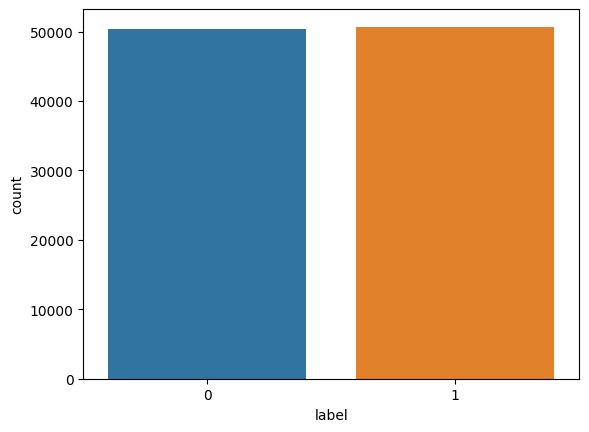

In [ ]:
#Visualizing the balance of the subset
balance_check_plot=sns.countplot(x='label', data=reddit_sample)

### **Text preprocessing**

In [ ]:
#Defining a function for text preprocessing

#Loading resources outside of the function
stemmer=PorterStemmer()
stop_words=set(stopwords.words('english'))

#Defining the function
def preprocess_text(text):

    '''This is a function for applying necessary preprocessing techniques on the text.'''

    #Lowercasing
    text=text.lower()

    #Remove punctuation
    text=text.translate(str.maketrans('', '', string.punctuation))

    #Tokenization, Stemming and Stopwords removal
    tokens=nltk.word_tokenize(text)
    text=' '.join([stemmer.stem(word) for word in tokens if word not in stop_words])

    return text

In [ ]:
#Applying preprocessing function to each parent comment in the subset
reddit_sample['parent_comment']=reddit_sample['parent_comment'].apply(preprocess_text)

### **Feature Engineering and Target Defining**

In [ ]:
#TF-IDF Vectorization
vectorizer=TfidfVectorizer()
X_text=vectorizer.fit_transform(reddit_sample['parent_comment'])

#One-Hot Encoding for subreddit
encoder=OneHotEncoder(sparse=True)
subreddit_one_hot_sparse=encoder.fit_transform(reddit_sample[['subreddit']])

#Concatenating the features
X=scipy.sparse.hstack([X_text, subreddit_one_hot_sparse])

#Defining the target
y=reddit_sample['label']

### **Preparing Train and Test sets**

In [ ]:
#Splitting the data into train and test sets
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=101)

### **Model training process for classification and estimation (First Path)**


**1**.   **Logistic Regression**

**2**.   **K Nearest Neighbors (KNN)**

**3**.   **Decision Tree**

**4**.   **Random Forest**

#### **1. Logistic Regression**

In [ ]:
#Model training with cross validation
reg_clf=LogisticRegression(max_iter=1000)
reg_scores=cross_val_score(reg_clf, X_train, y_train, cv=4, scoring='accuracy')
print(f'Cross-validation scores: {reg_scores}')
print(f'Average cross-validation score: {np.mean(reg_scores):0.2f}')

Cross-validation scores: [0.57090567 0.5730326  0.56613573 0.570093  ]
Average cross-validation score: 0.57


In [ ]:
#Training the model on the entire train set
reg_clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
#Predictions
y_pred_reg=reg_clf.predict(X_test)
print('Number of correct classifications:', accuracy_score(y_test,y_pred_reg,normalize=False))
print('Accuracy:', accuracy_score(y_test,y_pred_reg,normalize=True))

Number of correct classifications: 11697
Accuracy: 0.5785724884997774


In [ ]:
#Confusion matrix Analysis
reg_conf_matrix=confusion_matrix(y_test,y_pred_reg)
reg_conf_matrix

array([[5781, 4345],
       [4175, 5916]])

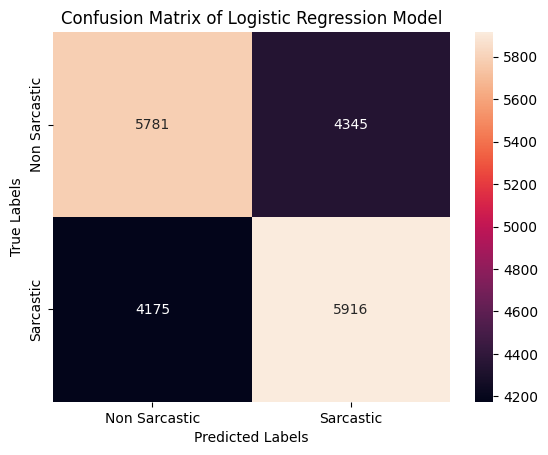

In [ ]:
#Visualizing confusion matrix
ax=plt.subplot()
sns.heatmap(reg_conf_matrix, annot=True, ax=ax, fmt='d');
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix of Logistic Regression Model')
ax.xaxis.set_ticklabels(['Non Sarcastic', 'Sarcastic']);
ax.yaxis.set_ticklabels(['Non Sarcastic', 'Sarcastic']);

In [ ]:
#Classification report Analysis
print(classification_report(y_test, y_pred_reg))

              precision    recall  f1-score   support

           0       0.58      0.57      0.58     10126
           1       0.58      0.59      0.58     10091

    accuracy                           0.58     20217
   macro avg       0.58      0.58      0.58     20217
weighted avg       0.58      0.58      0.58     20217



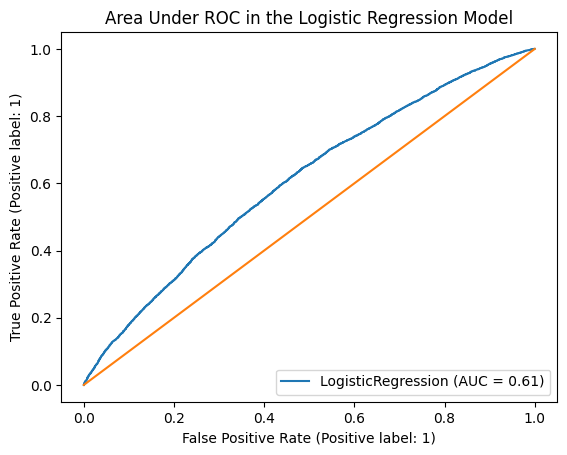

In [ ]:
#Visualizing ROC Curve
RocCurveDisplay.from_estimator(reg_clf,X_test,y_test)
plt.plot([0,1],[0,1])
plt.title('Area Under ROC in the Logistic Regression Model');

In [ ]:
#Getting probabilities of receiving a sarcastic comment
y_prob_reg=reg_clf.predict_proba(X_test)[:, 1]

#Output the probabilities
prob_df=pd.DataFrame(np.round(y_prob_reg,2), columns=['Probability'])
prob_df['label']=y_test.reset_index(drop=True)
prob_df

,Probability,label
0,0.49,1
1,0.67,1
2,0.54,1
3,0.35,0
4,0.39,0
...,...,...
20212,0.39,0
20213,0.46,0
20214,0.34,0
20215,0.41,0


In [ ]:
#Accuracy check of probabilities of receiving a sarcastic comment
prob_pred_acc_reg=np.round(roc_auc_score(y_test, y_prob_reg),2)
prob_pred_acc_reg

0.61

#### **2. K Nearest Neighbors (KNN)**

In [ ]:
#Model training with cross validation
knn_clf=KNeighborsClassifier(n_neighbors=3, algorithm='brute', metric='cosine')
knn_scores=cross_val_score(knn_clf, X_train, y_train, cv=4)
print(f'Cross-validation scores: {knn_scores}')
print(f'Average cross-validation score: {np.mean(knn_scores):0.2f}')

Cross-validation scores: [0.53093931 0.5275758  0.53521963 0.52864068]
Average cross-validation score: 0.53


In [ ]:
#Training the model on the entire train set
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='brute', metric='cosine', n_neighbors=3)

In [ ]:
#Predictions
y_pred_knn=knn_clf.predict(X_test)
print('Number of correct classifications:', accuracy_score(y_test,y_pred_knn,normalize=False))
print('Accuracy:', accuracy_score(y_test,y_pred_knn,normalize=True))

Number of correct classifications: 10768
Accuracy: 0.5326210614829104


In [ ]:
#Confusion matrix Analysis
knn_conf_matrix=confusion_matrix(y_test,y_pred_knn)
knn_conf_matrix

array([[6170, 3956],
       [5493, 4598]])

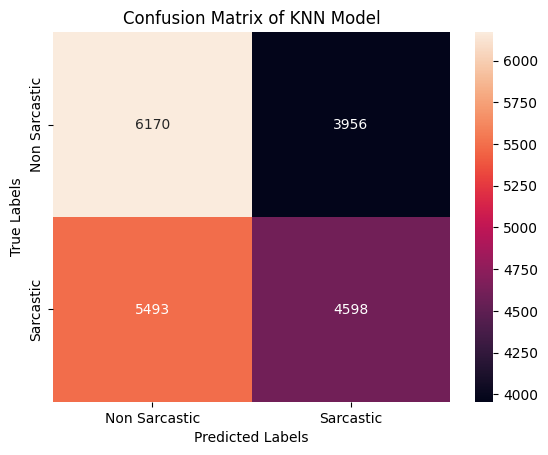

In [ ]:
#Visualizing confusion matrix
ax=plt.subplot()
sns.heatmap(knn_conf_matrix, annot=True, ax=ax, fmt='d');
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix of KNN Model')
ax.xaxis.set_ticklabels(['Non Sarcastic', 'Sarcastic']);
ax.yaxis.set_ticklabels(['Non Sarcastic', 'Sarcastic']);

In [ ]:
#Classification report Analysis
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.53      0.61      0.57     10126
           1       0.54      0.46      0.49     10091

    accuracy                           0.53     20217
   macro avg       0.53      0.53      0.53     20217
weighted avg       0.53      0.53      0.53     20217



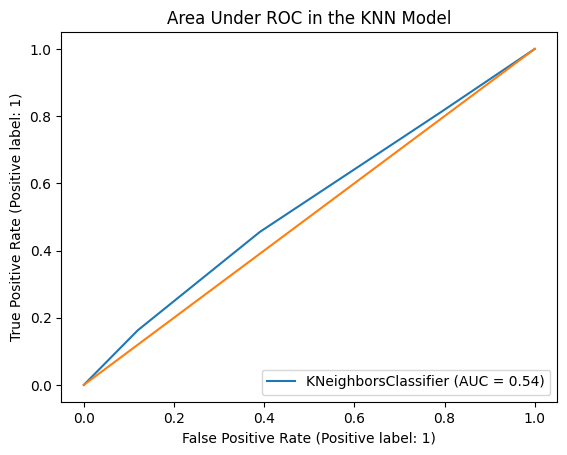

In [ ]:
#Visualizing ROC Curve
RocCurveDisplay.from_estimator(knn_clf,X_test,y_test)
plt.plot([0,1],[0,1])
plt.title('Area Under ROC in the KNN Model');

In [ ]:
#Getting probabilities of receiving a sarcastic comment
y_prob_knn=knn_clf.predict_proba(X_test)[:, 1]

#Output the probabilities
prob_df=pd.DataFrame(np.round(y_prob_knn,2), columns=['Probability'])
prob_df['label']=y_test.reset_index(drop=True)
prob_df

,Probability,label
0,0.67,1
1,0.00,1
2,0.33,1
3,0.33,0
4,0.67,0
...,...,...
20212,0.67,0
20213,0.67,0
20214,0.00,0
20215,0.67,0


In [ ]:
#Accuracy check of probabilities of receiving a sarcastic comment
prob_pred_acc_knn=np.round(roc_auc_score(y_test, y_prob_knn),2)
prob_pred_acc_knn

0.54

#### **3. Decision Tree**

In [ ]:
#Model training with cross validation
tree_clf=DecisionTreeClassifier(max_depth=10, random_state=101)
tree_scores=cross_val_score(tree_clf, X_train, y_train, cv=4, scoring='accuracy')
print(f'Cross-validation scores: {tree_scores}')
print(f'Average cross-validation score: {np.mean(tree_scores):0.2f}')

Cross-validation scores: [0.53276945 0.53450067 0.52958053 0.53383459]
Average cross-validation score: 0.53


In [ ]:
#Training the model on the entire train set
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=101)

In [ ]:
#Predictions
y_pred_tree=tree_clf.predict(X_test)
print('Number of correct classifications:', accuracy_score(y_test,y_pred_tree,normalize=False))
print('Accuracy:', accuracy_score(y_test,y_pred_tree,normalize=True))

Number of correct classifications: 10785
Accuracy: 0.533461937972993


In [ ]:
#Confusion matrix Analysis
tree_conf_matrix=confusion_matrix(y_test,y_pred_tree)
tree_conf_matrix

array([[8875, 1251],
       [8181, 1910]])

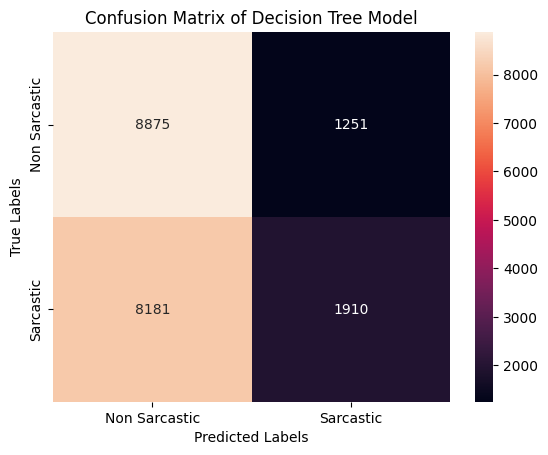

In [ ]:
#Visualizing confusion matrix
ax=plt.subplot()
sns.heatmap(tree_conf_matrix, annot=True, ax=ax, fmt='d');
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix of Decision Tree Model')
ax.xaxis.set_ticklabels(['Non Sarcastic', 'Sarcastic']);
ax.yaxis.set_ticklabels(['Non Sarcastic', 'Sarcastic']);

In [ ]:
#Classification report Analysis
print(classification_report(y_test, y_pred_tree))

              precision    recall  f1-score   support

           0       0.52      0.88      0.65     10126
           1       0.60      0.19      0.29     10091

    accuracy                           0.53     20217
   macro avg       0.56      0.53      0.47     20217
weighted avg       0.56      0.53      0.47     20217



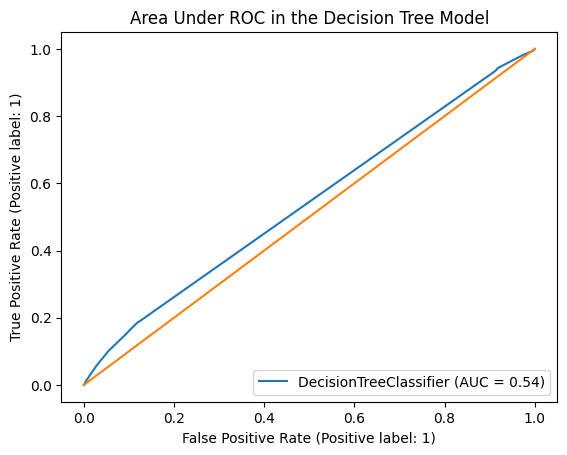

In [ ]:
#Visualizing ROC Curve
RocCurveDisplay.from_estimator(tree_clf,X_test,y_test)
plt.plot([0,1],[0,1])
plt.title('Area Under ROC in the Decision Tree Model');

In [ ]:
#Getting probabilities of receiving a sarcastic comment
y_prob_tree=tree_clf.predict_proba(X_test)[:, 1]

#Output the probabilities
prob_df=pd.DataFrame(np.round(y_prob_tree,2), columns=['Probability'])
prob_df['label']=y_test.reset_index(drop=True)
prob_df

,Probability,label
0,0.39,1
1,0.49,1
2,0.49,1
3,0.49,0
4,0.49,0
...,...,...
20212,0.49,0
20213,0.49,0
20214,0.34,0
20215,0.49,0


In [ ]:
#Accuracy check of probabilities of receiving a sarcastic comment
prob_pred_acc_tree=np.round(roc_auc_score(y_test, y_prob_tree),2)
prob_pred_acc_tree

0.54

#### **4. Random Forest**

In [ ]:
#Model training with cross validation
forest_clf=RandomForestClassifier(n_estimators=10, random_state=101, n_jobs=-1)
forest_scores=cross_val_score(forest_clf, X_train, y_train, cv=4, scoring='accuracy')
print(f'Cross-validation scores: {forest_scores}')
print(f'Average cross-validation score: {np.mean(forest_scores):0.2f}')

Cross-validation scores: [0.54256319 0.55027947 0.54590423 0.54427186]
Average cross-validation score: 0.55


In [ ]:
#Training the model on the entire train set
forest_clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=101)

In [ ]:
#Predictions
y_pred_forest=forest_clf.predict(X_test)
print('Number of correct classifications:', accuracy_score(y_test,y_pred_forest,normalize=False))
print('Accuracy:', accuracy_score(y_test,y_pred_forest,normalize=True))

Number of correct classifications: 11154
Accuracy: 0.5517139041400801


In [ ]:
#Confusion matrix Analysis
forest_conf_matrix=confusion_matrix(y_test,y_pred_forest)
forest_conf_matrix

array([[6473, 3653],
       [5410, 4681]])

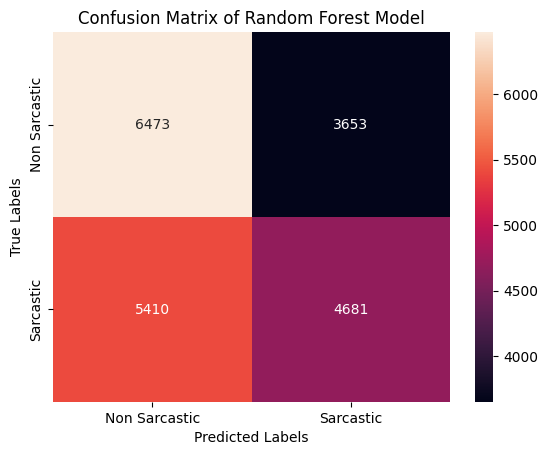

In [ ]:
#Visualizing confusion matrix
ax=plt.subplot()
sns.heatmap(forest_conf_matrix, annot=True, ax=ax, fmt='d');
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix of Random Forest Model')
ax.xaxis.set_ticklabels(['Non Sarcastic', 'Sarcastic']);
ax.yaxis.set_ticklabels(['Non Sarcastic', 'Sarcastic']);

In [ ]:
#Classification report Analysis
print(classification_report(y_test, y_pred_forest))

              precision    recall  f1-score   support

           0       0.54      0.64      0.59     10126
           1       0.56      0.46      0.51     10091

    accuracy                           0.55     20217
   macro avg       0.55      0.55      0.55     20217
weighted avg       0.55      0.55      0.55     20217



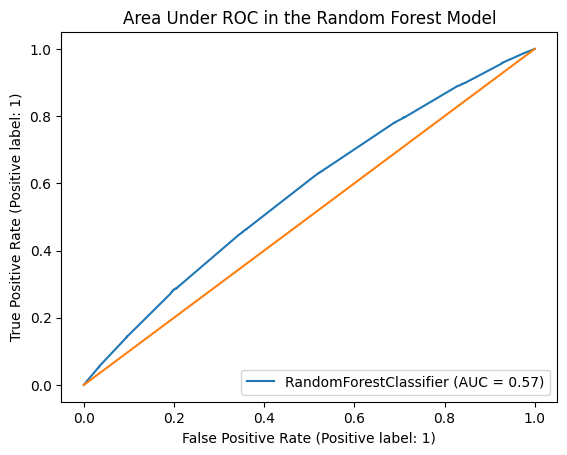

In [ ]:
#Visualizing ROC Curve
RocCurveDisplay.from_estimator(forest_clf,X_test,y_test)
plt.plot([0,1],[0,1])
plt.title('Area Under ROC in the Random Forest Model');

In [ ]:
#Getting probabilities of receiving a sarcastic comment
y_prob_forest=forest_clf.predict_proba(X_test)[:, 1]

#Output the probabilities
prob_df=pd.DataFrame(np.round(y_prob_forest,2), columns=['Probability'])
prob_df['label']=y_test.reset_index(drop=True)
prob_df

,Probability,label
0,0.50,1
1,0.60,1
2,0.40,1
3,0.10,0
4,0.62,0
...,...,...
20212,0.20,0
20213,0.50,0
20214,0.50,0
20215,0.40,0


In [ ]:
#Accuracy check of probabilities of receiving a sarcastic comment
prob_pred_acc_forest=np.round(roc_auc_score(y_test, y_prob_forest),2)
prob_pred_acc_forest

0.57

### **Results Comparison**

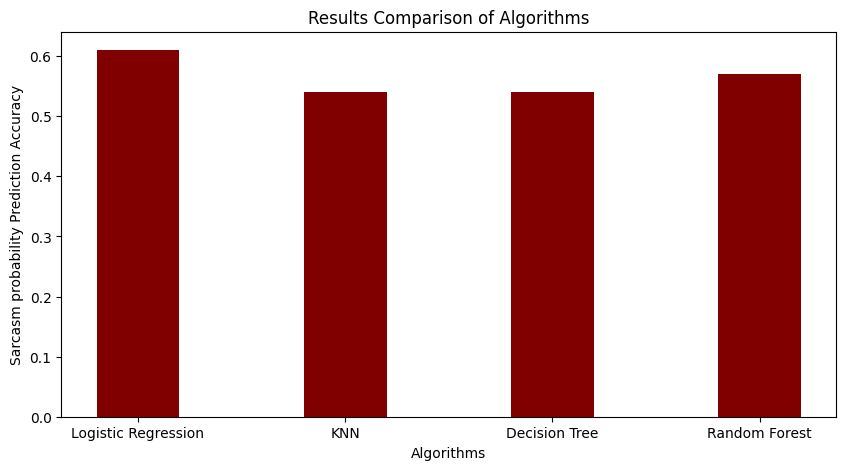

In [ ]:
#Visualizing accuracy of the algorithms in sarcasm probability prediction
algorithms=['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest']
accu=[prob_pred_acc_reg, prob_pred_acc_knn, prob_pred_acc_tree, prob_pred_acc_forest]

#Creating the bar plot
fig=plt.figure(figsize=(10,5))
plt.bar(algorithms, accu, color='maroon', width=0.4)
plt.xlabel('Algorithms')
plt.ylabel('Sarcasm probability Prediction Accuracy')
plt.title('Results Comparison of Algorithms')
plt.show()

### **More Optimized Approach (Second Path)**

In [ ]:
#Instantiating the models
reg_clf_2=LogisticRegression(max_iter=1000)
knn_clf_2=KNeighborsClassifier(n_neighbors=3, algorithm='brute', metric='cosine')
tree_clf_2=DecisionTreeClassifier(max_depth=10, random_state=101)
forest_clf_2=RandomForestClassifier(n_estimators=10, random_state=101, n_jobs=-1)

#Training the models on the entire train set (Extracted from the subset)
reg_clf_2.fit(X_train, y_train)
knn_clf_2.fit(X_train, y_train)
tree_clf_2.fit(X_train, y_train)
forest_clf_2.fit(X_train, y_train)

#Creating model objects
models=[reg_clf_2, knn_clf_2, tree_clf_2, forest_clf_2]

#Creating cross-validation object
cv_final=StratifiedKFold(n_splits=4)

#Evaluating each model with cross validation method
algorithms=[]
cv_scores=[]
for model in models:
    scores=cross_val_score(model, X, y, cv=cv_final, scoring=make_scorer(accuracy_score))
    algorithms.append(model.__class__.__name__)
    cv_scores.append(scores.mean())
    print(f'{model.__class__.__name__}: {scores.mean():0.2f} ± {scores.std():0.2f}')

#Presenting the best classification algorithm, among these four algorithms
index_max=cv_scores.index(max(cv_scores))
print(f'The best algorithm is: {algorithms[index_max]} with a score of: {cv_scores[index_max]:0.2f}')

LogisticRegression: 0.57 ± 0.00
KNeighborsClassifier: 0.53 ± 0.00
DecisionTreeClassifier: 0.53 ± 0.00
RandomForestClassifier: 0.55 ± 0.00
The best algorithm is: LogisticRegression with a score of: 0.57


In [ ]:
#Reviewing the whole dataset to use for prediction in the best algorithm, which will be the result of the cross validation evaluation
reddit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010773 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


In [ ]:
#Applying preprocessing function to each parent comment in the whole dataset
reddit_df['parent_comment']=reddit_df['parent_comment'].apply(preprocess_text)

In [ ]:
#TF-IDF Vectorization
vectorizer=TfidfVectorizer()
X_text_2=vectorizer.fit_transform(reddit_df['parent_comment'])

#One-Hot Encoding for subreddit
encoder=OneHotEncoder(sparse=True)
subreddit_one_hot_sparse_2=encoder.fit_transform(reddit_df[['subreddit']])

#Combining Features
X_2=scipy.sparse.hstack([X_text_2, subreddit_one_hot_sparse_2])

#Defining the target
y_2=reddit_df['label']

In [ ]:
#Splitting the data into train and test sets
X_train_2, X_test_2, y_train_2, y_test_2=train_test_split(X_2, y_2, test_size=0.2, random_state=101)

In [ ]:
#Training the best model on the entire train set (Extracted from the whole dataset)
reg_clf_2.fit(X_train_2, y_train_2)

LogisticRegression(max_iter=1000)

In [ ]:
#Predictions in the whole dataset
y_pred_reg_2=reg_clf_2.predict(X_test_2)
print('Number of correct classifications:', accuracy_score(y_test_2,y_pred_reg_2,normalize=False))
print('Accuracy:', accuracy_score(y_test_2,y_pred_reg_2,normalize=True))

Number of correct classifications: 120310
Accuracy: 0.5951050127123255


In [ ]:
#Confusion matrix Analysis (Whole Dataset)
reg_conf_matrix_2=confusion_matrix(y_test_2,y_pred_reg_2)
reg_conf_matrix_2

array([[59511, 41338],
       [40518, 60799]])

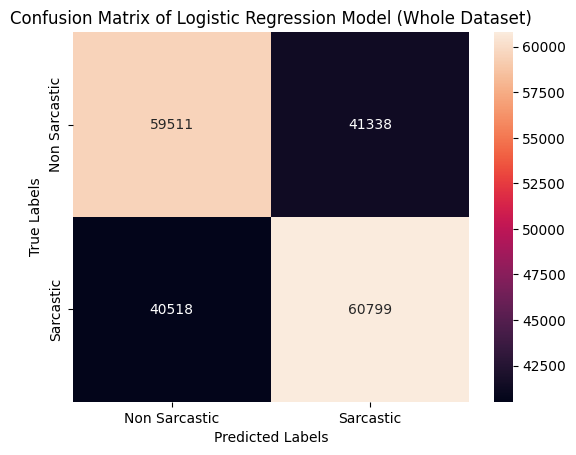

In [ ]:
#Visualizing confusion matrix (Whole Dataset)
ax=plt.subplot()
sns.heatmap(reg_conf_matrix_2, annot=True, ax=ax, fmt='d');
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix of Logistic Regression Model (Whole Dataset)')
ax.xaxis.set_ticklabels(['Non Sarcastic', 'Sarcastic']);
ax.yaxis.set_ticklabels(['Non Sarcastic', 'Sarcastic']);

In [ ]:
#Classification report Analysis (Whole Dataset)
print(classification_report(y_test_2, y_pred_reg_2))

              precision    recall  f1-score   support

           0       0.59      0.59      0.59    100849
           1       0.60      0.60      0.60    101317

    accuracy                           0.60    202166
   macro avg       0.60      0.60      0.60    202166
weighted avg       0.60      0.60      0.60    202166



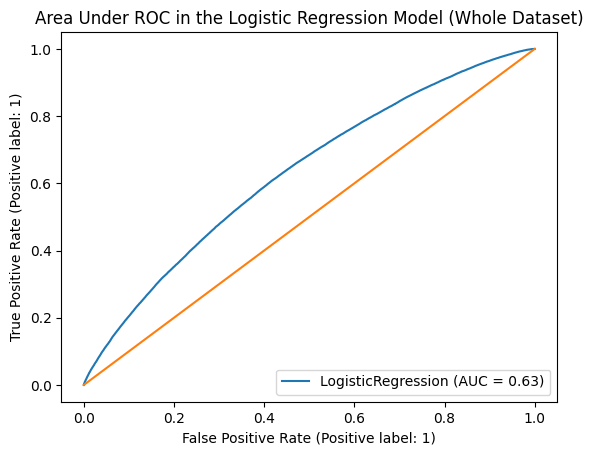

In [ ]:
#Visualizing ROC Curve (Whole Dataset)
RocCurveDisplay.from_estimator(reg_clf_2,X_test_2,y_test_2)
plt.plot([0,1],[0,1])
plt.title('Area Under ROC in the Logistic Regression Model (Whole Dataset)');

In [ ]:
#Getting probabilities of receiving a sarcastic comment (Whole Dataset)
y_prob_reg_2=reg_clf_2.predict_proba(X_test_2)[:, 1]

#Output the probabilities
prob_df=pd.DataFrame(np.round(y_prob_reg_2,2), columns=['Probability'])
prob_df['label']=y_test_2.reset_index(drop=True)
prob_df

,Probability,label
0,0.59,0
1,0.87,0
2,0.55,1
3,0.42,0
4,0.59,1
...,...,...
202161,0.47,1
202162,0.45,0
202163,0.69,0
202164,0.42,1


In [ ]:
#Accuracy check of probabilities of receiving a sarcastic comment (Whole Dataset)
prob_pred_acc_reg_2=np.round(roc_auc_score(y_test_2, y_prob_reg_2),2)
prob_pred_acc_reg_2

0.63